In [1]:
%%javascript
require(["codemirror/keymap/sublime", "notebook/js/cell", "base/js/namespace"],
    function(sublime_keymap, cell, IPython) {
        cell.Cell.options_default.cm_config.keyMap = 'sublime';
        var cells = IPython.notebook.get_cells();
        for(var cl=0; cl< cells.length ; cl++){
            cells[cl].code_mirror.setOption('keyMap', 'sublime');
        }
    }
);

In [2]:
# change the cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.print_figure_kwargs={'facecolor' : "w"}
import warnings
warnings.filterwarnings('ignore')
# import all relevant func and modules from a companion .py file
from supp_lib import *

In [4]:
# assortment of relevant BED files with the features of interest ...
rloops_ONLY = "intersect-Rloops-NO-all-NT-CTCF-NO-G4-Mao"
ctcf_peaks_w_G4 = "intersect-all-NT-CTCF-NO-Rloops-G4-Mao"
ctcf_peaks_ONLY = "intersect-all-NT-CTCF-NO-Rloops-NO-G4-Mao"

# K562 -different cell line
allRloops = "GSM1720619_K562_DRIP_peaks-sort.bed"
allG4 = "G4-Mao-sort"

# differential splicing events: noCTCF - CTCF(without TIR1)
splice_deltaCTCF = "S44_NT_S442_IAA.output_events_all_select_hg19.txt"
# now it's a DDX5 mutant ...AAVS is a control for DDX55 clone
splice_deltaDDX55 = "AAVS1_sg24_NT_DDX55_sg2B_NT.output_events_all_select_hg19.txt"

bounds = "noctcf_bounds.bed"
feature_of_interest = bounds

## Read `feature_of_interest` that we want to look at using stackups ...
### we can also generate some random locations from hg19 using `generate_random_bed` ...

In [5]:
# bf is short for bioframe here ...
df = bf.read_table(
    feature_of_interest,
    names=["chrom","start","end"]
)
df = df.sort_values(["chrom","start"])
df = df[~(df["chrom"] == "chrM")]
df = df.reset_index(drop=True)

### explore spacing and footprints of the features being explored ...

simply plot distributions of the spacings between adjacent features and their sizes `end - start`  as well ...


Text(0, 0.5, '# features')

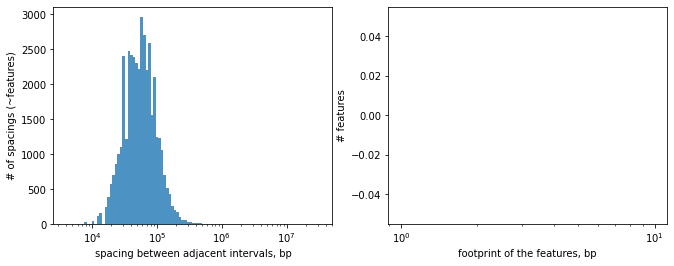

In [6]:
# calculate "spacing" between adjacent features,
# assuming coordinates are sorted !
spacings = np.concatenate(
    [ np.diff(_df["start"].values) for _, _df in df.groupby("chrom") ]
)
# calculate footprints of the features ...
footprints = (df["end"] - df["start"]).values

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,4))

bins_spacing = np.geomspace(spacings.min()+1,spacings.max(),num=100)
ax1.hist(spacings, bins=bins_spacing, log=False, alpha=0.8)
ax1.set_xscale("log")
ax1.set_xlabel("spacing between adjacent intervals, bp")
ax1.set_ylabel("# of spacings (~features)")

bins_footprint = np.geomspace(footprints.min(),footprints.max(),num=100)
ax2.hist(footprints, bins=bins_footprint, log=False, alpha=0.8)
ax2.set_xscale("log")
ax2.set_xlabel("footprint of the features, bp")
ax2.set_ylabel("# features")


### in our analyses (insulation/compartments) we wouldn't resolve features that are too close ...
#### let's see what clustering those adjacent ones could do for us
#### let's try to pick a good clustering "radius" first - should be  around ~1-10kb ...

it's actually merging that we're doing - i.e. we don't need to know cluster information - just need to collapse nearby intervals into larger ones

to see how varying clustering radius affects the results see the gist : blah ...

In [7]:
merge_radius = 1_000
df_merged = bf.merge(df, min_dist=merge_radius)
print(f"number of candidate features before and after merging: {len(df)} -> {len(df_merged)}")

number of candidate features before and after merging: 40937 -> 40937


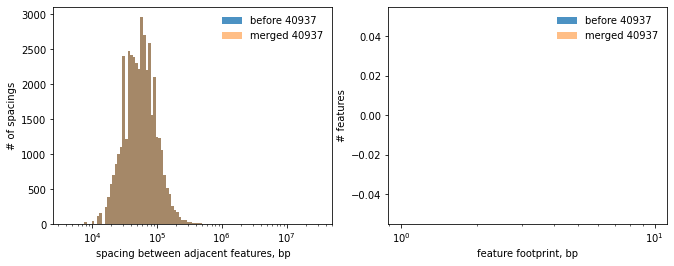

In [8]:
# RE-calculate "spacing" between adjacent features after merging them:
# assuming coordinates are sorted
spcs_merged = np.concatenate(
    [ np.diff(_df["start"].values) for _, _df in df_merged.groupby("chrom") ]
)
# RE-calculate footprints of the features, after merging ...
footprints_merged = (df_merged["end"] - df_merged["start"]).values

fig,(ax1,ax2) = plt.subplots(1,2,figsize=(11,4))

ax1.hist(spacings, bins=bins_spacing, log=False, alpha=0.8, label=f"before {len(df)}")
ax1.hist(spcs_merged, bins=bins_spacing, log=False, alpha=0.5, label=f"merged {len(df_merged)}")
ax1.set_xscale("log")
ax1.set_xlabel("spacing between adjacent features, bp")
ax1.set_ylabel("# of spacings")
ax1.legend(frameon=False)

ax2.hist(footprints, bins=bins_footprint, log=False, alpha=0.8, label=f"before {len(df)}")
ax2.hist(footprints_merged, bins=bins_footprint, log=False, alpha=0.5, label=f"merged {len(df_merged)}")
ax2.set_xscale("log")
ax2.set_xlabel("feature footprint, bp")
ax2.set_ylabel("# features")
ax2.legend(frameon=False)


### after we explored how our features (intervals) are spaced and distributed
#### we can move on to the stackups - for different samples, different types of tracks, etc

In [9]:
bw_fnames = OrderedDict()
# bw_fnames["ins_noCTCF"] = "CTCFdegron-442-auxin-rep1.25kb.insul_score_250000.bw"
# bw_fnames["ins_CTCF"] = "CTCFdegron-442-nontreated-rep1.25kb.insul_score_250000.bw"
# bw_fnames["ev1_250kb_CTCF"] = "CTCFdegron-442-nontreated-rep1.250kb.eigs.cis.vecs.bw"
bw_fnames["ev1_CTCF"] = "allcools.EV1.25kb.bw"
bw_fnames["ev1_noCTCF"] = "noCTCF_IAA_combined.EV1.25kb.bw"
bw_fnames["ins_WT"] = "Hap1-WT-combined.2kb.20kb.bw"
bw_fnames["ins_CTCF"] = "all_CTCF_combined.hg19.2kb.20kb.bw" # deeper versions - combined
bw_fnames["ins_noCTCF"] = "noCTCF_IAA_combined.hg19.2kb.20kb.bw" # deeper version - combined

# bw_fnames["ins_DDX"] = "CkoCT442-AAVS1sg2-4-NT-R1-T1__hg19.2kb.20kb.bw"
# bw_fnames["ins_noDDX"] = "CkoCT442-DDX55sg2-B-NT-R1-T1__hg19.2kb.20kb.bw"

bw_fnames["ins_PolII"] = "PolII-NT.hg19.2kb.20kb.bw"
bw_fnames["ins_noPolII"] = "PolII-IAA.hg19.2kb.20kb.bw"


bw_fnames["ins250_CTCF"] = "CTCFdegron-442-nontreated-rep1.25kb.insul_score_250000.bw"
bw_fnames["ins250_noCTCF"] = "CTCFdegron-442-auxin-rep1.25kb.insul_score_250000.bw"

bw_fnames["rad21_CTCF"] = "NT-RAD21_R1.mLb.clN.bigWig"
bw_fnames["rad21_noCTCF"] = "IAA-RAD21_R1.mLb.clN.bigWig"
bw_fnames["ctcf"] = "NT-CTCF_R1.mLb.clN.bigWig"
bw_fnames["noctcf"] = "IAA-CTCF_R1.mLb.clN.bigWig"
bw_fnames["ddx_CTCF"] = "NT-DDX55_R1.mLb.clN.bigWig"
bw_fnames["ddx_noCTCF"] = "IAA-DDX55_R1.mLb.clN.bigWig"


In [10]:
# set some stackups paramters - plotting and stacking ....
titles = [ k for k in bw_fnames ]

binsizes = {}
for s in ["ev1_CTCF","ev1_noCTCF"]:
    binsizes[s] = 25_000
# insulation
for s in ["ins_WT","ins_CTCF","ins_noCTCF","ins_PolII","ins_noPolII"]:
    binsizes[s] = 2_000
for s in ["ins250_CTCF","ins250_noCTCF"]:
    binsizes[s] = 25_000
# chip-seq
for s in ["rad21_CTCF","rad21_noCTCF","ctcf","noctcf","ddx_CTCF","ddx_noCTCF"]:
    binsizes[s] = 250


flanks = {}
for s in ["ev1_CTCF","ev1_noCTCF"]:
    flanks[s] = 100_000
# insulation
for s in ["ins_WT","ins_CTCF","ins_noCTCF","ins_PolII","ins_noPolII"]:
    flanks[s] = 40_000
for s in ["ins250_CTCF","ins250_noCTCF"]:
    flanks[s] = 300_000
# chip-seq
for s in ["rad21_CTCF","rad21_noCTCF","ctcf","noctcf","ddx_CTCF","ddx_noCTCF"]:
    flanks[s] = 5_000

limss = {}
# (0.02,.6) - value
for s in ["ev1_CTCF","ev1_noCTCF"]:
    limss[s] = (-1,1)
# insulation
for s in ["ins_WT","ins_CTCF","ins_noCTCF","ins_PolII","ins_noPolII","ins250_CTCF","ins250_noCTCF"]:
    limss[s] = (-.5,.5)
# chip seq
for s in ["rad21_CTCF","rad21_noCTCF","ctcf","noctcf","ddx_CTCF","ddx_noCTCF"]:
    limss[s] = (0.,.25)

cmps = {}
for s in ["ev1_CTCF","ev1_noCTCF"]:
    cmps[s] = cmap1
# insulation
for s in ["ins_WT","ins_CTCF","ins_noCTCF","ins_PolII","ins_noPolII","ins250_CTCF","ins250_noCTCF"]:
    cmps[s] = cmap2
# chip seq
for s in ["rad21_CTCF","rad21_noCTCF","ctcf","noctcf","ddx_CTCF","ddx_noCTCF"]:
    cmps[s] = cmap3

norms = {}
# log scal color normalization: colors.LogNorm(*limss["rad21_CTCF"])
for s in ["ev1_CTCF","ev1_noCTCF"]:
    norms[s] = None
# insulation
for s in ["ins_WT","ins_CTCF","ins_noCTCF","ins_PolII","ins_noPolII","ins250_CTCF","ins250_noCTCF"]:
    norms[s] = None
# chip seq
for s in ["rad21_CTCF","rad21_noCTCF","ctcf","noctcf","ddx_CTCF","ddx_noCTCF"]:
    norms[s] = None


### next is computation heavy step - stackups using bbi ...

In [11]:
# do all stackups with the parameters ...
stackups = {}
for s in bw_fnames:
    print(f"stacking up {s} ...")
    %time stackups[s] = rstacks( bw_fnames[s], df_merged, flank=flanks[s], binsize=binsizes[s] )

stacking up ev1_CTCF ...
CPU times: user 3.63 s, sys: 176 ms, total: 3.81 s
Wall time: 3.74 s
stacking up ev1_noCTCF ...
CPU times: user 3.38 s, sys: 147 ms, total: 3.53 s
Wall time: 3.49 s
stacking up ins_WT ...
CPU times: user 4.72 s, sys: 249 ms, total: 4.97 s
Wall time: 4.95 s
stacking up ins_CTCF ...
CPU times: user 4.77 s, sys: 212 ms, total: 4.98 s
Wall time: 4.93 s
stacking up ins_noCTCF ...
CPU times: user 4.9 s, sys: 195 ms, total: 5.09 s
Wall time: 5.08 s
stacking up ins_PolII ...
CPU times: user 4.91 s, sys: 258 ms, total: 5.17 s
Wall time: 5.11 s
stacking up ins_noPolII ...
CPU times: user 4.67 s, sys: 222 ms, total: 4.89 s
Wall time: 4.84 s
stacking up ins250_CTCF ...
CPU times: user 3.29 s, sys: 106 ms, total: 3.4 s
Wall time: 3.36 s
stacking up ins250_noCTCF ...
CPU times: user 3.63 s, sys: 129 ms, total: 3.76 s
Wall time: 3.71 s
stacking up rad21_CTCF ...
CPU times: user 6.34 s, sys: 595 ms, total: 6.93 s
Wall time: 6.92 s
stacking up rad21_noCTCF ...
CPU times: user 5

### it's amazing how much you can do with a stack up !

we can flip certain rows !

_beware_ that we are reordering index this way, and we also might loos some rows from a stackup because of NaNs

In [12]:
# let's define how we flip things - by compartment status ...
ev1_arr = stackups["ev1_CTCF"]
preflip_index = np.arange(len(ev1_arr))
mid = int(ev1_arr.shape[1]/2)
# flip track: left average EV1 - right average EV1
ev_left_minus_right = np.nanmean(ev1_arr[:,:mid],axis=1) - \
       np.nanmean(ev1_arr[:,mid:],axis=1)

# flipped index according to EV1
flip_stackup_index = np.concatenate([
    preflip_index[ev_left_minus_right>=0],
    preflip_index[ev_left_minus_right<0]
])

# flip EVERYTHING according to the compartment
flip_stackups = {}
for s in bw_fnames:
    flip_stackups[s] = np.concatenate([
        stackups[s][ev_left_minus_right>=0],
        stackups[s][ev_left_minus_right<0][:,::-1]
    ])

# print flip condition numbers ...
print( (ev_left_minus_right>=0).sum() )
print( (ev_left_minus_right<0).sum() )
print( np.isnan(ev_left_minus_right).sum() ) # NaNs

20260
20451
226


In [13]:
flip_stackups['ins_mean'] = np.nanmean(flip_stackups['ins_noCTCF'][:,20-2:20+2],axis=1)

initial_index = np.arange( len(flip_stackups['ins_mean']) )
ks = [ ('ev1_CTCF',"clust",5), ('ins_mean',"sort",1) ]
_, jjj = recursive_data_ordering( ks, initial_index, flip_stackups, verbose=True)


clustering 40711 elements of ev1_CTCF into 5 groups ...
sorting 3085 elements of ins_mean into 1 groups ...
sorting 4514 elements of ins_mean into 1 groups ...
sorting 10188 elements of ins_mean into 1 groups ...
sorting 14023 elements of ins_mean into 1 groups ...
sorting 8901 elements of ins_mean into 1 groups ...


In [14]:
np.unique(jjj), len(stackups["ins_noCTCF"] )
# where do items dissappear ?!

(array([    0,     1,     2, ..., 40708, 40709, 40710]), 40937)

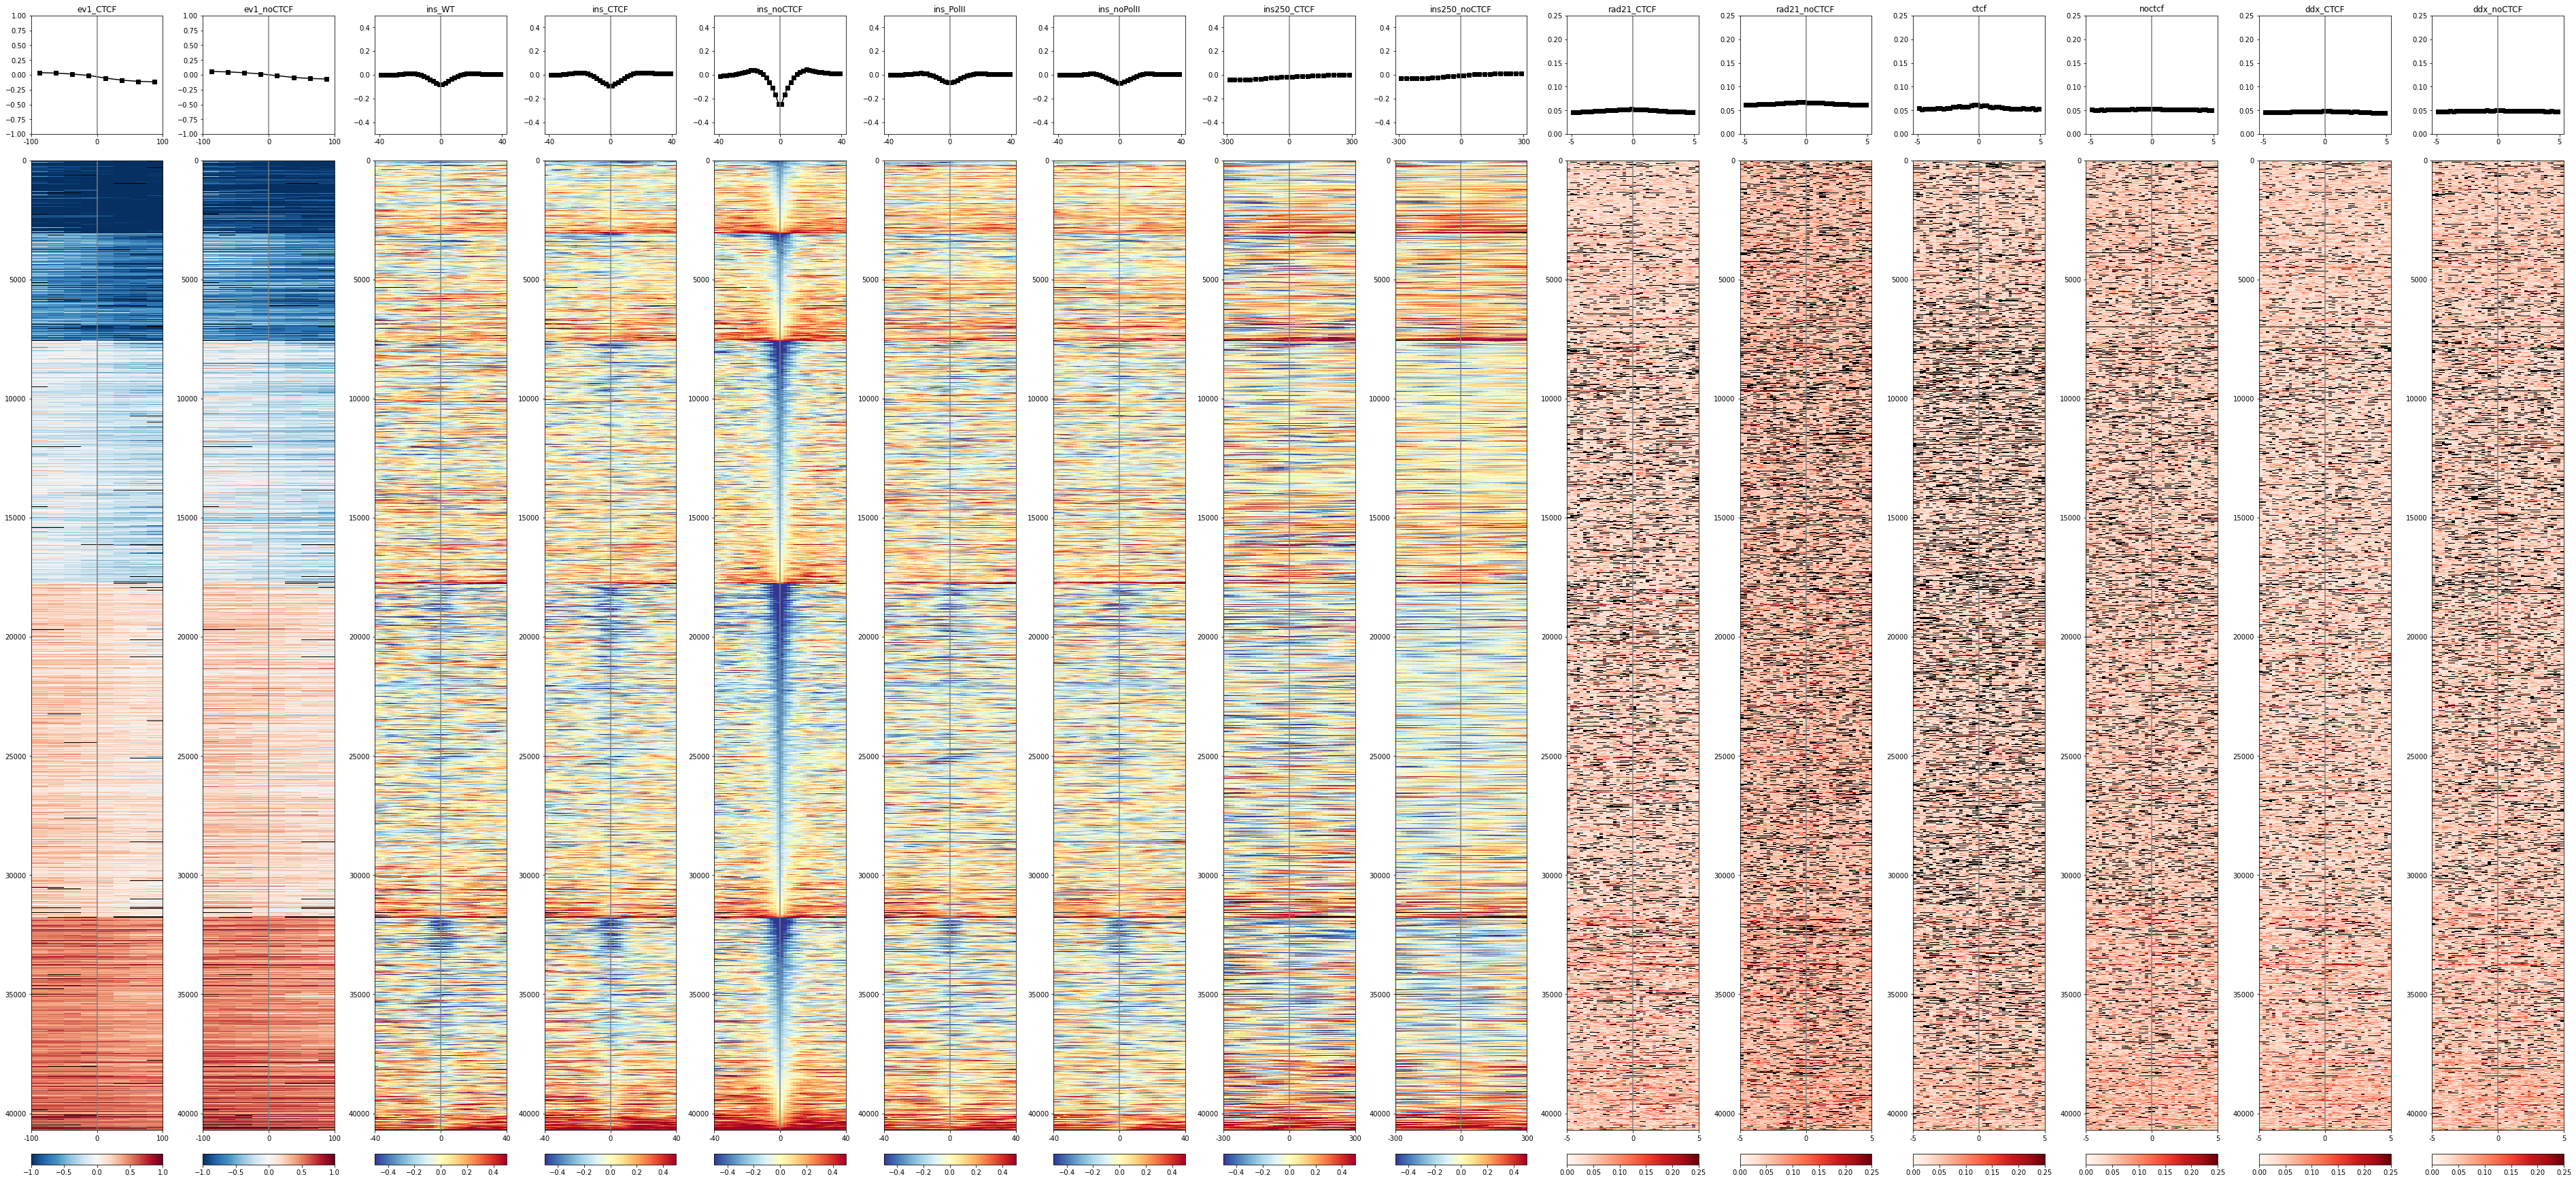

In [15]:
hmss = [ flip_stackups[_k][jjj] for _k in bw_fnames ]
_limss = [ limss[_k] for _k in bw_fnames ]
_cmps = [ cmps[_k] for _k in bw_fnames ]
_binsizes = [ binsizes[_k] for _k in bw_fnames ]
_norms = [ norms[_k] for _k in bw_fnames ]

plot_stackups(hmss,titles,_limss,_cmps,_norms,_binsizes,fname="xxx.png",fillmissing=False,interpolation="nearest")

In [16]:
# one can subselect any subset of the stackup and replot it again
iii = np.r_[jjj[:12_000]]
# jjj = np.r_[iii[1800:2400],iii[8500:9600]]

### Onoing stuff - unfinished

In [17]:
# trying to optimize heatmap interpolation for Chip-Seq data

# X = hmss[3]

# missing = ~np.isfinite(X)
# mu = np.nanmean(X, axis=0, keepdims=True) # - should I change that ?!
# X_hat0 = np.where(missing, mu, X)

# mu = np.nanmean(X, axis=1, keepdims=True) # - should I change that ?!
# X_hat1 = np.where(missing, mu, X)



# plt.imshow(
#   X_hat0,
#   norm=colors.LogNorm(.02,.6),
#   aspect=.2,
# #   vmin=_limss[3][0],
# #   vmax=_limss[3][1],
#   cmap="cividis_r",
#   interpolation="bilinear"
# )

# # Supported values are 'none', 'antialiased', 'nearest', 'bilinear',
# #     'bicubic', 'spline16', 'spline36', 'hanning', 'hamming', 'hermite',
# #     'kaiser', 'quadric', 'catrom', 'gaussian', 'bessel', 'mitchell',
# #     'sinc', 'lanczos'.

# # ar = (X_hat0 - X_hat1).flatten()
# # ar = ar[ar != 0.0]
# # plt.hist(ar,bins=100)
# plt.gcf().set_size_inches(8,8)

In [18]:
# https://github.com/open2c/cooltools/blob/53ce4fc11d046e84ca36f3591e9e5d548de9f7b2/cooltools/lib/peaks.py#L7
# this is where we need to look in order to extract the prominence calculation for our R-loop-stackups ...
# basically learn to apply such prominence searching technique to a small slice of an insulation track as opposed to the whole-chromosome applications ...

def find_peak_prominence(arr, max_dist=None):
    """Find the local maxima of an array and their prominence.
    The prominence of a peak is defined as the maximal difference between the
    height of the peak and the lowest point in the range until a higher
    # WTF - what is there is no higher peak - correct wording  ?!
    peak.
    Parameters
    ----------
    arr : array_like
    max_dist : int
        If specified, the distance to the adjacent higher peaks is limited
        by `max_dist`.
    Returns
    -------
    loc_max_poss : numpy.array
        The positions of local maxima of a given array.
    proms : numpy.array
        The prominence of the detected maxima.
    """

    arr = np.asarray(arr)
    n = len(arr)
    max_dist = len(arr) if max_dist is None else int(max_dist)

    # Finding all local minima and maxima (i.e. points the are lower/higher than
    # both immediate non-nan neighbors).
    arr_nonans = arr[~np.isnan(arr)]
    idxs_nonans2idx = np.arange(arr.size)[~np.isnan(arr)]

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        is_min_left = np.r_[False, arr_nonans[:-1] > arr_nonans[1:]]
        is_min_right = np.r_[arr_nonans[:-1] < arr_nonans[1:], False]
        is_loc_min = is_min_left & is_min_right
        loc_min_poss = np.where(is_loc_min)[0]
        loc_min_poss = idxs_nonans2idx[loc_min_poss]

        is_max_left = np.r_[False, arr_nonans[:-1] < arr_nonans[1:]]
        is_max_right = np.r_[arr_nonans[:-1] > arr_nonans[1:], False]
        is_loc_max = is_max_left & is_max_right
        loc_max_poss = np.where(is_loc_max)[0]
        loc_max_poss = idxs_nonans2idx[loc_max_poss]

    # For each maximum, find the position of a higher peak on the left and
    # on the right. If there are no higher peaks within the `max_dist` range,
    # just use the position `max_dist` away.
    left_maxs = -1 * np.ones(len(loc_max_poss), dtype=np.int)
    right_maxs = -1 * np.ones(len(loc_max_poss), dtype=np.int)

    for i, pos in enumerate(loc_max_poss):
        for j in range(pos - 1, -1, -1):
            if (arr[j] > arr[pos]) or (pos - j > max_dist):
                left_maxs[i] = j
                break

        for j in range(pos + 1, n):
            if (arr[j] > arr[pos]) or (j - pos > max_dist):
                right_maxs[i] = j
                break

    # Find the prominence of each peak with respect of the lowest point
    # between the peak and the adjacent higher peaks, on the left and the right
    # separately.
    left_max_proms = np.array(
        [
            (
                arr[pos] - np.nanmin(arr[left_maxs[i] : pos])
                if (left_maxs[i] >= 0)
                else np.nan
            )
            for i, pos in enumerate(loc_max_poss)
        ]
    )

    right_max_proms = np.array(
        [
            (
                arr[pos] - np.nanmin(arr[pos : right_maxs[i]])
                if (right_maxs[i] >= 0)
                else np.nan
            )
            for i, pos in enumerate(loc_max_poss)
        ]
    )

    # In 1D, the topographic definition of the prominence of a peak reduces to
    # the minimum of the left-side and right-side prominence.

    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)

        max_proms = np.nanmin(np.vstack([left_max_proms, right_max_proms]), axis=0)

    # The global maximum, by definition, does not have higher peaks around it and
    # thus its prominence is explicitly defined with respect to the lowest local
    # minimum. This issue arises only if max_dist was not specified, otherwise
    # the prominence of the global maximum is already calculated with respect
    # to the lowest point within the `max_dist` range.
    # If no local minima are within the `max_dist` range, just use the
    # lowest point.
    global_max_mask = (left_maxs == -1) & (right_maxs == -1)
    if (global_max_mask).sum() > 0:
        global_max_idx = np.where(global_max_mask)[0][0]
        global_max_pos = loc_max_poss[global_max_idx]
        neighbor_loc_mins = (loc_min_poss >= global_max_pos - max_dist) & (
            loc_min_poss < global_max_pos + max_dist
        )
        if np.any(neighbor_loc_mins):
            max_proms[global_max_idx] = arr[global_max_pos] - np.nanmin(
                arr[loc_min_poss[neighbor_loc_mins]]
            )
        else:
            max_proms[global_max_idx] = arr[global_max_pos] - np.nanmin(
                arr[max(global_max_pos - max_dist, 0) : global_max_pos + max_dist]
            )

    return loc_max_poss, max_proms